In [41]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import torch
import math
import torch.distributions as dists
from scem import loss, util, kernel, net, stein, cpdkernel
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import dirname, join
import pickle
import ksdmom.sampler as samp
from collections import namedtuple

In [43]:
results_path = './results/meanshift'
problem = 'StudentT_ontarget'

In [44]:
seed = 101
torch.manual_seed(seed)

In [45]:
font = {
    'family' : 'serif',
#     'weight' : 'bold',
    'size'   : 24
}
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', **font)
plt.rc('lines', linewidth=3, markersize=10)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [46]:
rep = 1
n_ps = 100
d = 5
m = torch.zeros(d)
df = 6
target = samp.IsotropicMultivariateStudentT(df, mean=m)

kimq  = kernel.KIMQ(b=-0.5)
loc = None
klin = kernel.KLinear(scale=1, loc=loc, bias=1)
ksum_imq = kernel.KSTSumKernel([klin, kimq])
q = 1
w_ = kernel.MultiquadraticWeight(p=(q-2)/2+1, bias=1, loc=loc, scale=1./df**0.5)
kw_ = kernel.KSTWeight(w_func=w_)
k_lin_grwth = kernel.KSTProduct(ksum_imq, kw_)

w_ = kernel.MultiquadraticWeight(p=(2+1+0.1)/2, bias=1, loc=loc, scale=1./df**0.5)
kw_ = kernel.KSTWeight(w_func=w_)
k_quad_grwth = kernel.KSTProduct(ksum_imq, kw_)


kernels = {
    'IMQ': kimq, 
    'IMQ-sum-lin': k_lin_grwth,
    # 'IMQ-sum-quad': k_quad_grwth,
}

In [47]:
dir_path = (join(results_path, problem))
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
rerun = True
vstat = True

In [48]:
sample_sizes = torch.logspace(0., 3.3, n_ps)
data = np.empty([len(kernels), rep, n_ps])
losses = {
    k: loss.KSD(v, target.score) 
    for k, v in kernels.items()
}
sampler = target
for l_i, (key, l) in enumerate(losses.items()):
    filename = (
        '{}.npy'.format(key) if not vstat else
        '{}_vstat.npy'.format(key)
    )
    path = os.path.join(dir_path, filename)
    if os.path.exists(path) and not rerun:
        tmp = np.load(path)
        data[l_i] = tmp
    else:
        for j, n in enumerate(sample_sizes):
            for i in range(rep):
                with util.TorchSeedContext(seed):
                    X = sampler.sample(int(n.item()))
                data[l_i, i, j] = l.loss(X, vstat=vstat,).detach().numpy()
        result = data[l_i]
        np.save(path, result)               

In [49]:
Format = namedtuple('Format', ['color', 'linestyle', 'marker'])
label_format_tuples = {
    'IMQ': ("IMQ ", Format('C1', '-', '*')),
    'IMQ-sum-lin': ('IMQ sum (lin.) $\\theta=0.1$', Format('C3', '--', 'o')),
#     'IMQ-sum-quad': ('IMQ sum (quad.) $\\theta=0.1$', Format('C5', '-.', 'v')),
}
ps = sample_sizes.detach().numpy()

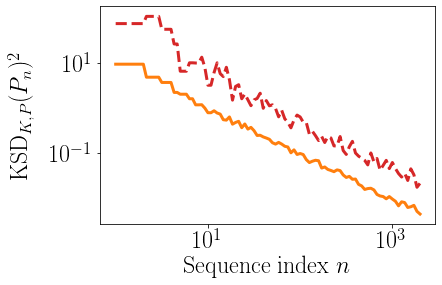

In [50]:
from matplotlib.ticker import LogLocator
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')


label = ax.set_xlabel('Sequence index $n$', fontsize = 24)
label = ax.set_ylabel('$\\mathrm{KSD}_{K, P}(P_n)^2$', fontsize = 24)   
# label.set_rotation(0)
# ax.xaxis.set_label_coords(0.5, -0.15)
# ax.yaxis.set_label_coords(-0.1, 1.05)   
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.2, 0.5)  
ax.set_yticks([1e+0, 1e+1, 1e+2])

ps = sample_sizes.detach().numpy()
for ki, key in enumerate(losses.keys()):
    label = label_format_tuples[key][0]
    fmt = label_format_tuples[key][1]
    y = data[ki].mean(axis=0)
#     y = data[ki][0]
    ax.plot(ps, y, label=label, 
        color=fmt.color, linestyle=fmt.linestyle)

#     error_low = (y - np.percentile(data[ki], q=5, axis=0))
#     error_high = np.percentile(data[ki], q=95, axis=0)-y
#     errors = np.vstack([error_low, error_high])
#     ax.errorbar(ps, y, yerr=errors,
#             color=fmt.color, label=label, linestyle=fmt.linestyle)
#     ax.violinplot(data[ki], ps, showmeans=True, showextrema=False, widths=1.5)

# ax.legend(bbox_to_anchor=(1.75,1.), ncol=4)
# plt.legend(bbox_to_anchor=(1.75,1.), ncol=2)
ax.set_yscale('log')
ax.set_xscale('log')

#ax.yaxis.set_minor_locator(LogLocator(numticks=10))
 
plt.savefig('ksd_studentt_ontarget_df{}.pdf'.format(df), bbox_inches='tight')
# plt.savefig('ksd_comparison_mean_shift_vstat.pdf', bbox_inches='tight')
# plt.savefig('ksd_comparison_mean_shift_legend_col2.pdf', bbox_inches='tight')
# plt.savefig('ksd_comparison_mean_shift_legend.pdf', bbox_inches='tight')